In [1]:
from netgan.netgan import *
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
print('A:', type(_A_obs), '\n', _A_obs)
print('X:', type(_X_obs), '\n', _X_obs)
print('z:', type(_z_obs), '\n', _z_obs)

A: <class 'scipy.sparse.csr.csr_matrix'> 
   (0, 1579)	1.0
  (0, 1581)	1.0
  (0, 2241)	1.0
  (1, 2)	1.0
  (1, 1123)	1.0
  (1, 1185)	1.0
  (1, 1864)	1.0
  (1, 2060)	1.0
  (1, 2170)	1.0
  (1, 2171)	1.0
  (2, 1)	1.0
  (2, 1038)	1.0
  (2, 1060)	1.0
  (2, 1804)	1.0
  (2, 2060)	1.0
  (2, 2306)	1.0
  (2, 2430)	1.0
  (3, 250)	1.0
  (3, 251)	1.0
  (3, 499)	1.0
  (4, 264)	1.0
  (4, 327)	1.0
  (4, 372)	1.0
  (4, 415)	1.0
  (4, 430)	1.0
  :	:
  (2802, 2288)	1.0
  (2802, 2289)	1.0
  (2802, 2293)	1.0
  (2802, 2342)	1.0
  (2802, 2345)	1.0
  (2802, 2351)	1.0
  (2802, 2505)	1.0
  (2802, 2507)	1.0
  (2802, 2782)	1.0
  (2802, 2794)	1.0
  (2803, 521)	1.0
  (2803, 1955)	1.0
  (2804, 1955)	1.0
  (2805, 639)	1.0
  (2805, 727)	1.0
  (2805, 769)	1.0
  (2805, 809)	1.0
  (2806, 851)	1.0
  (2806, 1032)	1.0
  (2807, 639)	1.0
  (2807, 2216)	1.0
  (2808, 198)	1.0
  (2808, 730)	1.0
  (2808, 1787)	1.0
  (2809, 1399)	1.0
X: <class 'scipy.sparse.csr.csr_matrix'> 
   (0, 1421)	0.08539067699819766
  (0, 1392)	0.1090265166

In [4]:
val_share = 0.1
test_share = 0.05
#seed = 481516234

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [7]:
print(train_graph)

  (0, 1579)	1.0
  (0, 2241)	1.0
  (1, 2)	1.0
  (1, 1185)	1.0
  (1, 1864)	1.0
  (1, 2060)	1.0
  (1, 2170)	1.0
  (1, 2171)	1.0
  (2, 1)	1.0
  (2, 1038)	1.0
  (2, 1060)	1.0
  (2, 1804)	1.0
  (2, 2060)	1.0
  (2, 2306)	1.0
  (2, 2430)	1.0
  (3, 251)	1.0
  (3, 499)	1.0
  (4, 264)	1.0
  (4, 372)	1.0
  (4, 415)	1.0
  (4, 430)	1.0
  (4, 441)	1.0
  (4, 444)	1.0
  (4, 461)	1.0
  (4, 1662)	1.0
  :	:
  (2802, 2258)	1.0
  (2802, 2288)	1.0
  (2802, 2289)	1.0
  (2802, 2293)	1.0
  (2802, 2342)	1.0
  (2802, 2345)	1.0
  (2802, 2351)	1.0
  (2802, 2507)	1.0
  (2802, 2782)	1.0
  (2802, 2794)	1.0
  (2803, 521)	1.0
  (2803, 1955)	1.0
  (2804, 1955)	1.0
  (2805, 639)	1.0
  (2805, 727)	1.0
  (2805, 769)	1.0
  (2805, 809)	1.0
  (2806, 851)	1.0
  (2806, 1032)	1.0
  (2807, 639)	1.0
  (2807, 2216)	1.0
  (2808, 198)	1.0
  (2808, 730)	1.0
  (2808, 1787)	1.0
  (2809, 1399)	1.0


#### Parameters

In [8]:
rw_len = 16
batch_size = 128

In [9]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [10]:
walker.walk().__next__()

array([[  39,   83, 1265, ...,  578,   86, 1421],
       [2292, 2259,  986, ...,  214,  359,  214],
       [ 481,  413,  453, ...,  441,  378, 2458],
       ...,
       [ 368, 1435,  290, ..., 1787,  198, 2808],
       [ 852,  939, 2240, ...,  797,  745,  796],
       [ 733, 2011,  733, ..., 1787,  160,  234]])

#### Create our NetGAN model

In [11]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


#### Define the stopping criterion

In [12]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [13]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_0.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****


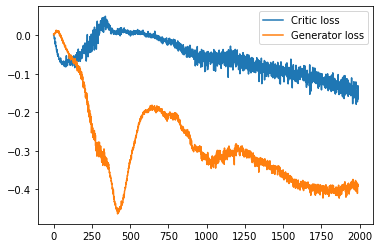

**** Iter 2000   Val ROC 0.829, AP: 0.838, EO 0.012 ****
2500   /200000   training iterations, took 270 seconds so far...


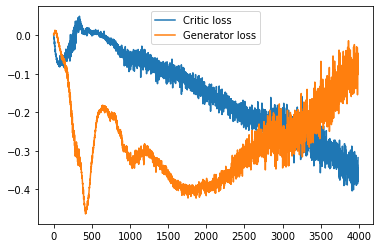

**** Iter 4000   Val ROC 0.880, AP: 0.886, EO 0.042 ****
5000   /200000   training iterations, took 541 seconds so far...


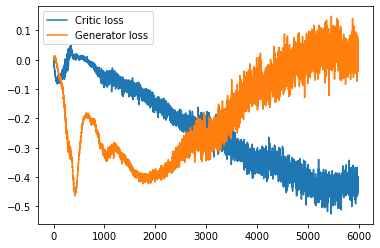

**** Iter 6000   Val ROC 0.893, AP: 0.897, EO 0.057 ****
7500   /200000   training iterations, took 808 seconds so far...


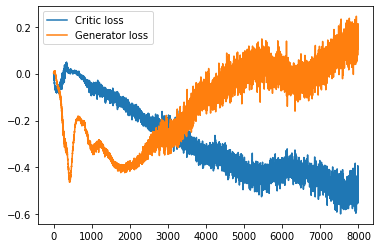

**** Iter 8000   Val ROC 0.892, AP: 0.902, EO 0.068 ****


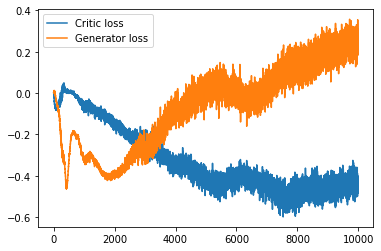

10000  /200000   training iterations, took 1074 seconds so far...
**** Iter 10000  Val ROC 0.908, AP: 0.917, EO 0.087 ****


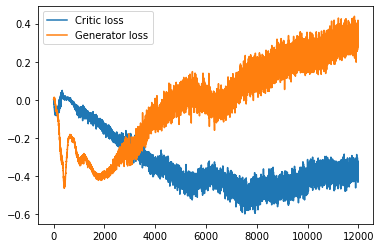

**** Iter 12000  Val ROC 0.921, AP: 0.930, EO 0.104 ****
12500  /200000   training iterations, took 1369 seconds so far...


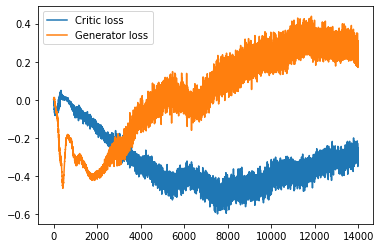

**** Iter 14000  Val ROC 0.933, AP: 0.939, EO 0.133 ****
15000  /200000   training iterations, took 1634 seconds so far...


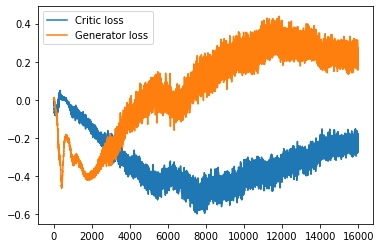

**** Iter 16000  Val ROC 0.931, AP: 0.937, EO 0.161 ****
17500  /200000   training iterations, took 1898 seconds so far...


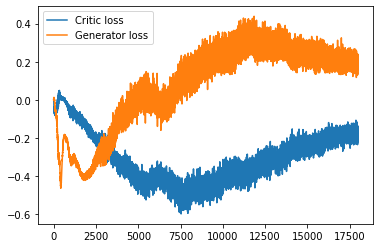

**** Iter 18000  Val ROC 0.934, AP: 0.942, EO 0.186 ****


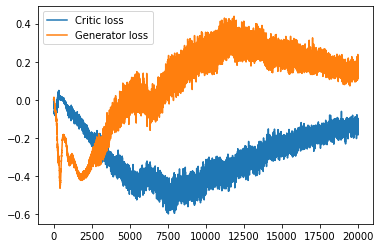

20000  /200000   training iterations, took 2164 seconds so far...
**** Iter 20000  Val ROC 0.935, AP: 0.941, EO 0.207 ****


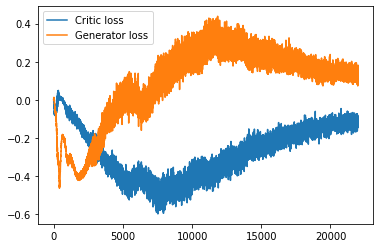

**** Iter 22000  Val ROC 0.934, AP: 0.940, EO 0.231 ****
22500  /200000   training iterations, took 2457 seconds so far...


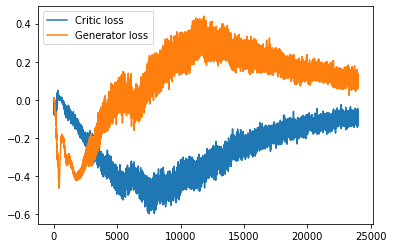

**** Iter 24000  Val ROC 0.937, AP: 0.942, EO 0.254 ****
25000  /200000   training iterations, took 2720 seconds so far...


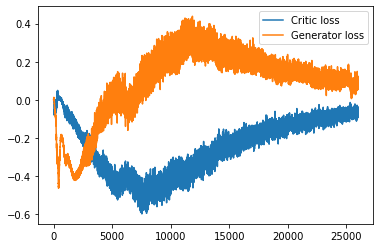

**** Iter 26000  Val ROC 0.942, AP: 0.948, EO 0.272 ****
27500  /200000   training iterations, took 2985 seconds so far...


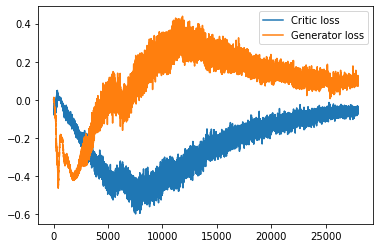

**** Iter 28000  Val ROC 0.940, AP: 0.947, EO 0.290 ****


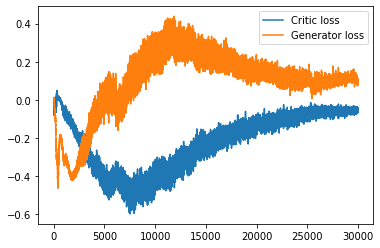

30000  /200000   training iterations, took 3249 seconds so far...
**** Iter 30000  Val ROC 0.940, AP: 0.947, EO 0.316 ****


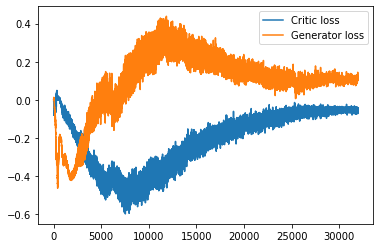

**** Iter 32000  Val ROC 0.939, AP: 0.945, EO 0.343 ****
32500  /200000   training iterations, took 3542 seconds so far...


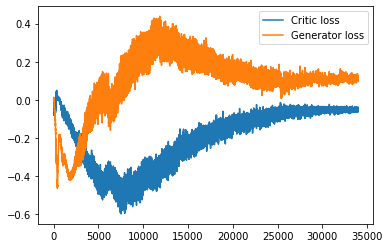

**** Iter 34000  Val ROC 0.935, AP: 0.942, EO 0.371 ****
35000  /200000   training iterations, took 3804 seconds so far...


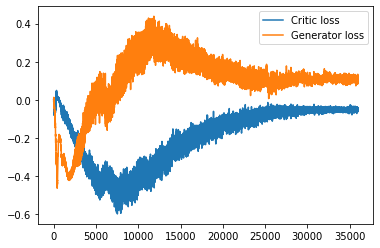

**** Iter 36000  Val ROC 0.937, AP: 0.944, EO 0.390 ****
37500  /200000   training iterations, took 4067 seconds so far...


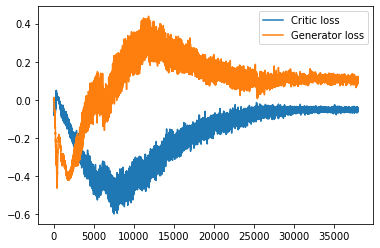

**** Iter 38000  Val ROC 0.935, AP: 0.941, EO 0.421 ****


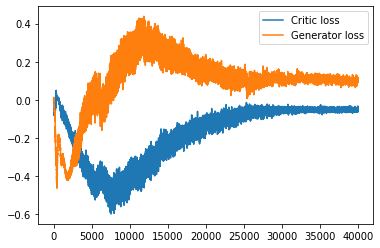

40000  /200000   training iterations, took 4332 seconds so far...
**** Iter 40000  Val ROC 0.938, AP: 0.943, EO 0.437 ****


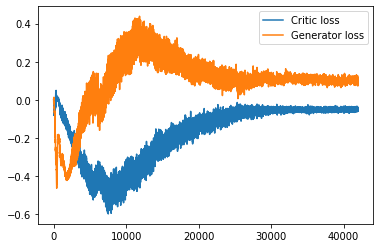

**** Iter 42000  Val ROC 0.928, AP: 0.934, EO 0.450 ****
42500  /200000   training iterations, took 4623 seconds so far...


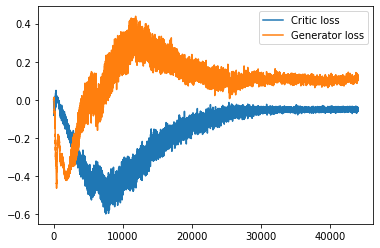

**** Iter 44000  Val ROC 0.933, AP: 0.937, EO 0.465 ****
45000  /200000   training iterations, took 4888 seconds so far...


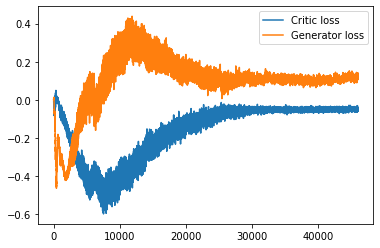

**** Iter 46000  Val ROC 0.932, AP: 0.937, EO 0.477 ****
47500  /200000   training iterations, took 5152 seconds so far...


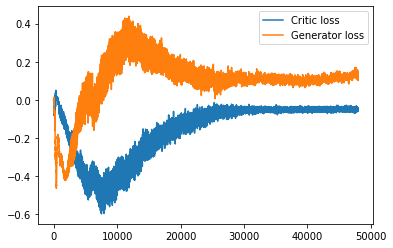

**** Iter 48000  Val ROC 0.935, AP: 0.939, EO 0.487 ****


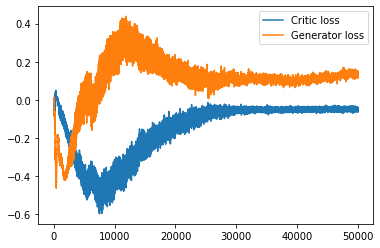

50000  /200000   training iterations, took 5414 seconds so far...
**** Iter 50000  Val ROC 0.932, AP: 0.936, EO 0.488 ****


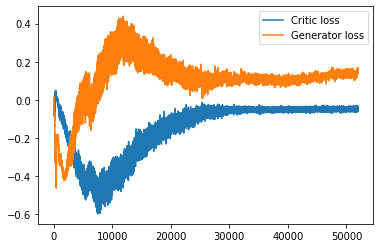

**** Iter 52000  Val ROC 0.934, AP: 0.938, EO 0.507 ****
52500  /200000   training iterations, took 5704 seconds so far...


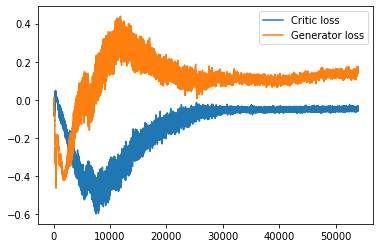

**** Iter 54000  Val ROC 0.932, AP: 0.936, EO 0.513 ****
55000  /200000   training iterations, took 5969 seconds so far...


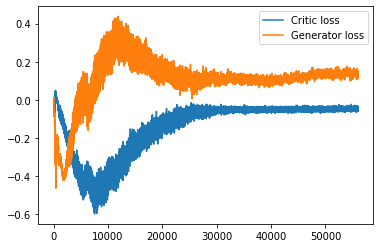

**** Iter 56000  Val ROC 0.933, AP: 0.936, EO 0.528 ****
57500  /200000   training iterations, took 6232 seconds so far...


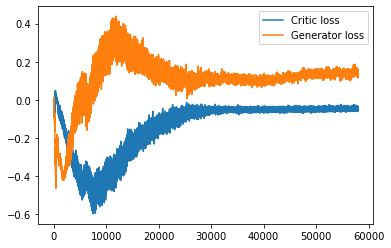

**** Iter 58000  Val ROC 0.929, AP: 0.934, EO 0.518 ****


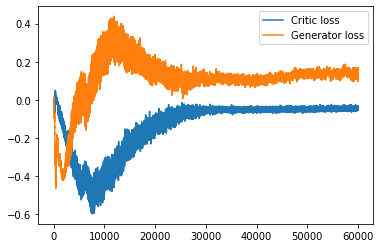

60000  /200000   training iterations, took 6497 seconds so far...
**** Iter 60000  Val ROC 0.928, AP: 0.933, EO 0.541 ****


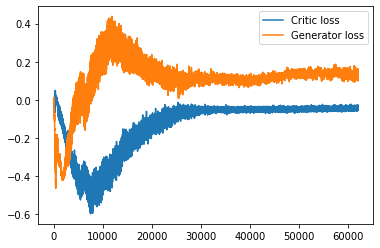

**** Iter 62000  Val ROC 0.929, AP: 0.934, EO 0.540 ****
62500  /200000   training iterations, took 6790 seconds so far...


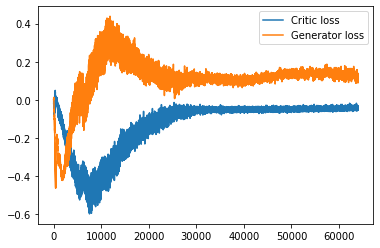

**** Iter 64000  Val ROC 0.927, AP: 0.932, EO 0.542 ****
65000  /200000   training iterations, took 7053 seconds so far...


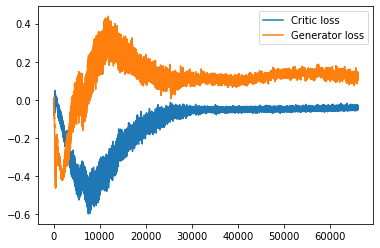

**** Iter 66000  Val ROC 0.932, AP: 0.936, EO 0.552 ****
**** EARLY STOPPING AFTER 66000 ITERATIONS ****
**** Training completed after 66000 iterations. ****


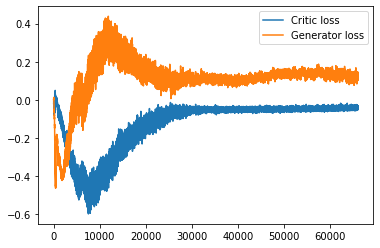

INFO:tensorflow:Restoring parameters from ../snapshots/model_best_0.ckpt


In [14]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=200000)

In [15]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

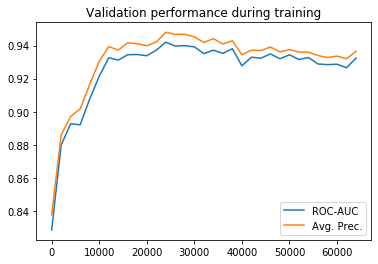

In [16]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

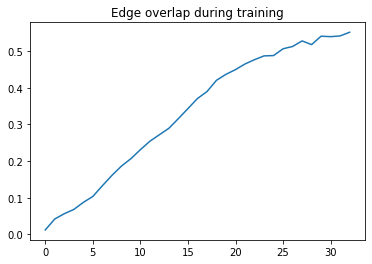

In [18]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [19]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [20]:
samples = []

In [21]:
for _ in range(6000):
    if (_+1) % 500 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

499
999
1499
1999
2499
2999
3499
3999
4499
4999
5499
5999


#### Assemble score matrix from the random walks

In [32]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [33]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [37]:
roc_auc_score(test_labels, test_scores)

0.9485468750000001

In [38]:
average_precision_score(test_labels, test_scores)

0.9563187636554668